In [1]:
#@title Convert json data to csv
import json
import os
import pandas as pd
import tqdm

gas_dic = {1:"CH4", 2:"CO2", 3:"Ar", 4:"Kr", 5:"Xe", 6:"O2", 7:"N2"}

inv_gas_dic = {v: k for k, v in gas_dic.items()}

GAS2ATTR = {
    "CH4":[0.295589,0.165132,0.251511019,-0.61518,0.026952,0.25887781],
    "CO2":[1.475242,1.475921,1.620478155,0.086439,1.976795,1.69928074],
    "Ar":[-0.11632,0.294448,0.1914686,-0.01667,-0.07999,-0.1631478],
    "Kr":[0.48802,0.602454,0.215485568,1.084671,0.415991,0.39885917],
    "Xe":[1.324657,0.751519,0.233498293,2.276323,1.12122,1.18462811],
    "O2":[-0.08095,0.37909,0.335570404,-0.61626,-0.5363,-0.1130181],
    "He":[-1.66617,-1.88746,-2.15618995,-0.9173,-1.36413,-1.6042445],
    "N2":[-0.37636,-0.3968,0.41962979,-0.31495,-0.40022,-0.3355659],
    "H2":[-1.34371,-1.3843,-1.11145188,-0.96708,-1.16031,-1.3256695],
}

directory = './MOFX-DB/CoREMOF_2019'

data_rows = []

for filename in tqdm.tqdm(os.listdir(directory)):
    if filename.endswith(".json"):
        filepath = os.path.join(directory, filename)
        try:
            with open(filepath, 'r') as f:
                data = json.load(f)
                name = data['name']
                
                gas = inv_gas_dic['CO2']
                gas_attr = GAS2ATTR['CO2']

                temperature = 320
                pressure = 20000

                data_rows.append({
                'name': name,
                'gas-name': gas,
                'gas-CriticalTemp': gas_attr[0],
                'gas-CriticalPressure': gas_attr[1],
                'gas-AcentricFactor': gas_attr[2],
                'gas-MolecularWeight': gas_attr[3],
                'gas-MeltPoint': gas_attr[4],
                'gas-BoilingPoint': gas_attr[5],
                'temperature': temperature,
                'pressure': pressure,
                })

        except json.JSONDecodeError:
            print(f"Error: Could not decode JSON in {filename}")
        except FileNotFoundError:
            print(f"Error: File not found: {filename}")

# Convert list of dicts to DataFrame
df = pd.DataFrame(data_rows)

# Export to CSV
df.to_csv("./MOFX-DB/CoREMOF_2019_data.csv", index=True)
print("Exported parsed data to data.csv")

100%|██████████| 24036/24036 [01:56<00:00, 206.94it/s]


Exported parsed data to data.csv


In [2]:
#@title Preprocess Data
from pymatgen.core import Structure
from pymatgen.transformations.standard_transformations import ConventionalCellTransformation
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.io.cif import CifParser
from multiprocessing import Process, Queue, Pool
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import pickle
import lmdb
import sys
import glob
import os
import re
from sklearn.preprocessing import MinMaxScaler
import itertools
import pdb
import random

def normalize_atoms(atom):
    return re.sub("\d+", "", atom)

def transform(cif_path):
    max_tolerance = 100
    s = CifParser(cif_path, occupancy_tolerance=max_tolerance)
    trans = ConventionalCellTransformation()
    s_trans = trans.apply_transformation(s.get_structures()[0])
    return s_trans

def cif_parser(cif_path, primitive=False):
    """
    Parser for single cif file
    """
    try:
        s = Structure.from_file(cif_path, primitive=primitive)
    except:
        s = transform(cif_path)
    id = cif_path.split('/')[-1][:-4]
    lattice = s.lattice
    abc = lattice.abc # lattice vectors
    angles = lattice.angles # lattice angles
    volume = lattice.volume # lattice volume
    lattice_matrix = lattice.matrix # lattice 3x3 matrix

    df = s.as_dataframe()
    atoms = df['Species'].astype(str).map(normalize_atoms).tolist()
    coordinates = df[['x', 'y', 'z']].values.astype(np.float32)
    abc_coordinates = df[['a', 'b', 'c']].values.astype(np.float32)
    assert len(atoms) == coordinates.shape[0]
    assert len(atoms) == abc_coordinates.shape[0]

    return {'ID':id,
            'atoms':atoms,
            'coordinates':coordinates,
            'abc':abc,
            'angles':angles,
            'volume':volume,
            'lattice_matrix':lattice_matrix,
            'abc_coordinates':abc_coordinates,
            }

def single_parser(content):
    dir_path = './MOFX-DB/CoREMOF_2019'
    cif_name, gas, gas_attr, temperature, pressure, targets, task_name = content
    cif_path = os.path.join(dir_path, cif_name+'.cif')
    if os.path.exists(cif_path):
        data = cif_parser(cif_path, primitive=False)
        data['gas'] = np.array(gas, dtype=np.int32)
        data['gas_attr'] = gas_attr.astype(np.float32)
        data['temperature'] = np.array(temperature, dtype=np.float32)
        data['pressure'] = np.array(np.log10(pressure), dtype=np.float32)
        data['target'] = np.array(targets, dtype=np.float32)
        data['task_name'] = task_name
        return pickle.dumps(data, protocol=-1)
    else:
        print(f'{cif_path} does not exit!')
        return None

def get_data(path):
    data = pd.read_csv(path)
    cif_names = 'name'
    gas = 'gas-name'
    gas_attr = ['gas-CriticalTemp', 'gas-CriticalPressure', 'gas-AcentricFactor', 'gas-MolecularWeight', 'gas-MeltPoint', 'gas-BoilingPoint']
    temperature = 'temperature'
    pressure = 'pressure'
    target = np.zeros((len(data), 1))
    data['task_name'] = data[cif_names].astype(str) + '#' + data[gas].astype(str) + '#' + data[temperature].astype(str) + '#' + data[pressure].astype(str)

    # print mean and std
    #value_log1p = np.log1p(data[columns])
    #_mean,_std = value_log1p.mean(), value_log1p.std()
    #print(f'mean and std of target values are: {_mean}, {_std}')

    return [(item[0], item[1], item[2], item[3], item[4], item[5], item[6]) for item in zip(data[cif_names], data[gas], data[gas_attr].values, data[temperature], data[pressure], target, data['task_name'])]

# split the database into train, validation and test set according to gases
def train_valid_test_split(data, train_ratio=0.8, valid_ratio=0.1, test_ratio=0.1):
    np.random.seed(42)
    id_list = [item[1] for item in data] ##gas_id
    unique_id_list = list(set(id_list))
    unique_id_list = np.random.permutation(unique_id_list)
    print(f'length of data is {len(data)}')
    print(f'length of unique_id_list is {len(unique_id_list)}')

    gas_dic = {1:"CH4", 2:"CO2", 3:"Ar", 4:"Kr", 5:"Xe", 6:"O2", 7:"N2"}
    gas_list = [1,2,3,4,5,6,7]

    print("*******************************")

    test_mat_id = 6
    test_id_list = np.array([test_mat_id])
    print("test_id_list:", gas_dic[test_mat_id])

    gas_list.remove(test_mat_id)
    valid_mat_id = random.sample(gas_list,1)
    valid_id_list = np.array([valid_mat_id])
    print("valid_id_list:", gas_dic[valid_mat_id[0]])

    gas_list.remove(valid_mat_id[0])
    train_id_list = np.array(gas_list)
    print("train_id_list:", train_id_list)

    train_data = [item for item in data if item[1] in train_id_list]
    valid_data = [item for item in data if item[1] in valid_id_list]
    test_data = [item for item in data if item[1] in test_id_list]

    print("*******************************")
    print(f'train_len:{len(train_data)}')
    print(f'valid_len:{len(valid_data)}')
    print(f'test_len:{len(test_data)}')

    return train_data, valid_data, test_data

def rand_test_split(data, num_samples):
    np.random.seed(10)
    np.random.shuffle(data)
    test_data = data[:num_samples]
    return [], [], test_data

def myfunc(func, arg):
    for item in arg:   
        yield func(item)

from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

def write_lmdb(inpath='./', outpath='./', nthreads=8):
    data = get_data(inpath)
    print(data[0])

    for name, content in [('test.lmdb', data)]:
        outputfilename = os.path.join(outpath, name)
        os.makedirs(os.path.dirname(outputfilename), exist_ok=True)
        try:
            os.remove(outputfilename)
        except:
            pass

        env_new = lmdb.open(
            outputfilename,
            subdir=False,
            readonly=False,
            lock=False,
            readahead=False,
            meminit=False,
            max_readers=1,
            map_size=int(1e9),
        )
        txn_write = env_new.begin(write=True)

        # Use ThreadPoolExecutor instead of Pool
        with ThreadPoolExecutor(max_workers=nthreads) as executor:
            futures = {executor.submit(single_parser, item): item for item in content}
            i = 0
            for future in tqdm(as_completed(futures), total=len(content)):
                inner_output = future.result()
                if inner_output is not None:
                    txn_write.put(f'{i}'.encode("ascii"), inner_output)
                    i += 1
                    if i % 1000 == 0:
                        txn_write.commit()
                        txn_write = env_new.begin(write=True)
            print('{} process {} lines'.format(name, i))
            txn_write.commit()
            env_new.close()

inpath = './MOFX-DB/CoREMOF_2019_data.csv' # replace to your data path
outpath = './MOFX-DB' # replace to your out path

write_lmdb(inpath=inpath, outpath=outpath, nthreads=12)


('1499489-acs.cgd.6b01265_1499490_clean', 2, array([1.475242  , 1.475921  , 1.62047816, 0.086439  , 1.976795  ,
       1.69928074]), 320, 20000, array([0.]), '1499489-acs.cgd.6b01265_1499490_clean#2#320#20000')


100%|██████████| 12018/12018 [48:36<00:00,  4.12it/s] 

test.lmdb process 12018 lines


In [ ]:
!./inference_scripts/infer-MOFX-DB.sh

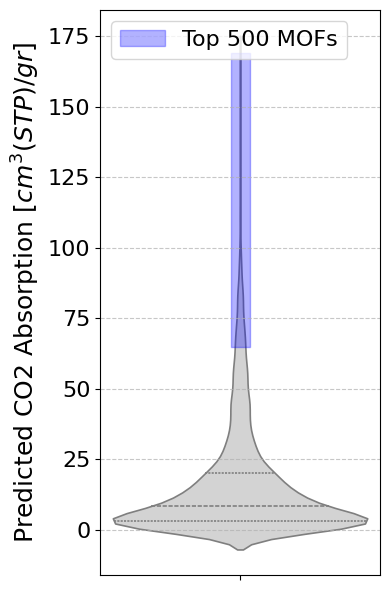

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
import pandas as pd

# Load the data
with open('./evaluation_MOFX_DB/weights_test.out.pkl', 'rb') as f:
    results = pickle.load(f)

# Extract predictions and names
all_preds = []
all_names = []

for entry in results:
    preds = entry['predict'].cpu().numpy().flatten()
    names = entry['task_name']

    all_preds.extend(preds)
    all_names.extend(names)

# Mapping from gas ID to gas name
gas_dic = {1: "CH4", 2: "CO2", 3: "Ar", 4: "Kr", 5: "Xe", 6: "O2", 7: "N2"}

# Filter for CO2 predictions
co2_preds = []
co2_names = []

for pred, name in zip(all_preds, all_names):
    parts = name.split('#')
    gas_id = int(parts[1])
    if gas_id == 2:  # CO2 gas ID
        co2_preds.append(pred)
        co2_names.append(name)

# Sort by predictions to find the top 500 MOFs for CO2 absorption
sorted_indices = np.argsort(co2_preds)[::-1]  # Sort in descending order
top_500_indices = sorted_indices[:500]

# Extract the top 500 predictions
top_500_preds = [co2_preds[i] for i in top_500_indices]
top_500_names = [co2_names[i].split('#')[0] for i in top_500_indices]

# Save the top 500 names and predictions to a DataFrame
top_500_df = pd.DataFrame({
    "MOF Name": top_500_names,
    "Predicted CO2 Absorption": top_500_preds
})

# Create a DataFrame for Seaborn
data = pd.DataFrame({
    "Predicted CO2 Absorption": co2_preds
})

# Plot the violin plot
plt.figure(figsize=(4, 6))
sns.violinplot(
    y="Predicted CO2 Absorption",
    data=data,
    scale="width",
    inner="quartile",
    color="lightgray",
    linewidth=1.2
)

# Highlight the region inside the violin plot for the top 500 predictions
# Get the min and max of the top 500 predictions
top_500_min = min(top_500_preds)
top_500_max = max(top_500_preds)

# Overlay a shaded region inside the violin plot
plt.fill_betweenx(
    y=[top_500_min, top_500_max],
    x1=-0.03,  # Adjust based on the violin width
    x2=0.03,   # Adjust based on the violin width
    color="blue",
    alpha=0.3,
    label="Top 500 MOFs"
)

# Add labels and title
plt.ylabel("Predicted CO2 Absorption [$cm^3(STP)/gr$]", fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel("",)
plt.legend(loc="upper left", fontsize=16)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [17]:
# Write the DataFrame to a CSV file
output_csv_path = "./MOFX-DB/top_500_co2_mofs.csv"
top_500_df.to_csv(output_csv_path, index=False)
print(f"Top 500 MOFs saved to {output_csv_path}")

Top 500 MOFs saved to ./MOFX-DB/top_500_co2_mofs.csv


In [20]:
def single_parser(content):
    dir_path = './MOFX-DB/CoREMOF_2019'  # replace with your MOF database path
    cif_name, targets = content
    cif_path = os.path.join(dir_path, cif_name + '.cif')
    if os.path.exists(cif_path):
        try:
            data = cif_parser(cif_path, primitive=False)
            data['mof-name'] = cif_name
            data['target'] = 1
            return pickle.dumps(data, protocol=-1)
        except ValueError as e:
            print(f"Error processing {cif_path}: {e}")
            return None
    else:
        print(f"{cif_path} does not exist!")
        return None
    
def get_data(path):
    data = pd.read_csv(path)
    cif_names = 'MOF Name'
    capacity = 'Predicted CO2 Absorption'

    return [(item[0], item[1]) for item in zip(data[cif_names], data[capacity])]

    
inpath = './MOFX-DB/top_500_co2_mofs.csv' # replace to your data path
outpath = './MOFX-DB-Top500' # replace to your out path

write_lmdb(inpath=inpath, outpath=outpath, nthreads=12)

('WOMXED_clean', 169.1)


100%|██████████| 500/500 [06:54<00:00,  1.21it/s]

test.lmdb process 500 lines


In [31]:
import pandas as pd
import pickle
import numpy as np

# Define a softmax function
def softmax(logits):
    exp_logits = np.exp(logits - np.max(logits))  # Subtract max for numerical stability
    return exp_logits / exp_logits.sum(axis=-1, keepdims=True)

# Load the inference results
with open('./evaluation_top500/logs_mostly_freeze_weighted_test.out.pkl', 'rb') as f:
    inference_results = pickle.load(f)

# Extract logits and names
mof_names = []
logits_list = []
predicted_classes = []


for entry in inference_results:
    predicted_class = entry['predict'].detach().cpu().numpy().flatten()
    logits = entry['logits'].detach().cpu().numpy()  # Assuming logits are stored in the 'logits' field
    name = entry['mof-name']
    predicted_classes.append(predicted_class)
    logits_list.append(logits)
    mof_names.append(name)

# Create a DataFrame for analysis
results_df = pd.DataFrame({
    "MOF Name": mof_names,
    "Predicted Class": predicted_classes
})

# Compute softmax probabilities
softmax_probs = np.array([softmax(logits) for logits in logits_list]).squeeze()

# Extract confidence for class 4 (TS class)
class_4_confidences = softmax_probs[:, 3]  # Assuming class 4 corresponds to index 3

# Filter MOFs with confidence > 90% for class 3
high_confidence_indices = np.where(class_4_confidences > 0.9)[0]
high_confidence_mofs = [mof_names[i] for i in high_confidence_indices]
high_confidence_probs = class_4_confidences[high_confidence_indices]

# Save the filtered MOFs to a DataFrame
high_confidence_filtered_df = pd.DataFrame({
    "MOF Name": high_confidence_mofs,
    "Class 4 Confidence": high_confidence_probs
})

# Write the DataFrame to a CSV file
output_csv_path = "./evaluation_top500/high_confidence_ts_class_mofs.csv"
high_confidence_filtered_df.to_csv(output_csv_path, index=False)
print(f"High-confidence MOFs in TS class (class 4) saved to {output_csv_path}")

# Display the filtered MOFs
print("High-confidence MOFs in TS class (class 4):")
print(high_confidence_filtered_df)

# Filter for MOFs in the TS class (class 3)
ts_class_mofs = results_df[results_df["Predicted Class"] == 4]

# Save the filtered MOFs to a CSV file
output_csv_path = "./evaluation_top500/TS_class_mofs.csv"
ts_class_mofs.to_csv(output_csv_path, index=False)
print(f"MOFs in TS class (class 4) saved to {output_csv_path}")

# Display the filtered MOFs
print("MOFs in TS class (class 4):")
print(ts_class_mofs)

High-confidence MOFs in TS class (class 4) saved to ./evaluation_top500/high_confidence_ts_class_mofs.csv
High-confidence MOFs in TS class (class 4):
                            MOF Name  Class 4 Confidence
0                     [BEDYEQ_clean]            0.939453
1                     [QEFWUV_clean]            0.936035
2  [ja5111317_ja5111317_si_002_auto]            0.934082
3           [ja507269n_si_002_clean]            0.978027
4                     [BUNKUS_clean]            0.913574
5                     [LEVDIB_clean]            0.924805
MOFs in TS class (class 4) saved to ./evaluation_top500/TS_class_mofs.csv
MOFs in TS class (class 4):
                           MOF Name Predicted Class
3                    [UXOHOG_clean]             [4]
9                    [MAVRAE_clean]             [4]
11                 [VETTAR_charged]             [4]
15                 [VETSOE_charged]             [4]
16                   [DOGBAE_clean]             [4]
..                              ...  

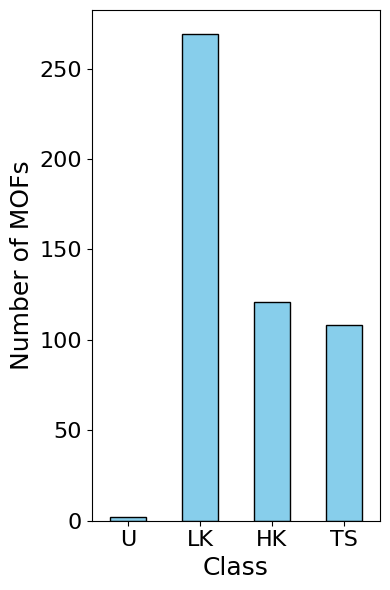

In [36]:
import matplotlib.pyplot as plt

# Define class labels
class_labels = ["U", "LK", "HK", "TS"]  # Update as needed

# Count the number of MOFs in each class
class_counts = results_df["Predicted Class"].value_counts()

# Plot the bar graph
plt.figure(figsize=(4, 6))  # Shrink the plot size
class_counts.sort_index().plot(kind="bar", color="skyblue", edgecolor="black")

# Add labels and title with larger font sizes
plt.xlabel("Class", fontsize=18)
plt.ylabel("Number of MOFs", fontsize=18)
plt.xticks(ticks=range(len(class_labels)), labels=class_labels, rotation=0, fontsize=16)  # Use class labels
plt.yticks(fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()